In [2]:
from config.config import CONFIGURATION_PATH
import utils.analysis_utils as hlpeda
import utils.images_utils as hlpimage
from matplotlib import pyplot as plt
from IPython.display import display
import utils.read_utils as hlpread
from datetime import timedelta
import seaborn as sns
import pandas as pd
import numpy as np 
#import cudf 
import gc
import os


In [ ]:
current_dir = os.path.dirname(os.path.realpath('__file__'))
PROJECT_ROOT = os.path.abspath(os.path.join(current_dir, os.pardir))

In [ ]:
TRANSACTION_DATA = os.path.join(PROJECT_ROOT, 
                                hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','data_folders'),
                                hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','interim_data'),
                                hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','transaction_data'),
                            )


TRANSACTION_DATA = os.path.splitext(TRANSACTION_DATA)[0] + '.pkl'

In [3]:
train_tran = hlpread.read_from_pickle(TRANSACTION_DATA) 
train_tran.head()

,t_dat,customer_id,article_id,price,online_sale
1,2018-09-20,-6846340800584936,541518023,0.030487,True
2,2018-09-20,-8334631767138808638,505221004,0.015236,True
3,2018-09-20,-8334631767138808638,685687003,0.016937,True
4,2018-09-20,-8334631767138808638,685687004,0.016937,True
5,2018-09-20,-8334631767138808638,685687001,0.016937,True


In [4]:
max_t_date = train_tran.t_dat.max()
min_t_date = train_tran.t_dat.min()

print(f'Transaction records from: {min_t_date} to {max_t_date}')

Transaction records from: 2018-09-20 00:00:00 to 2020-09-22 00:00:00


### Question: **What is the frequency of transaction by users and items?** ###

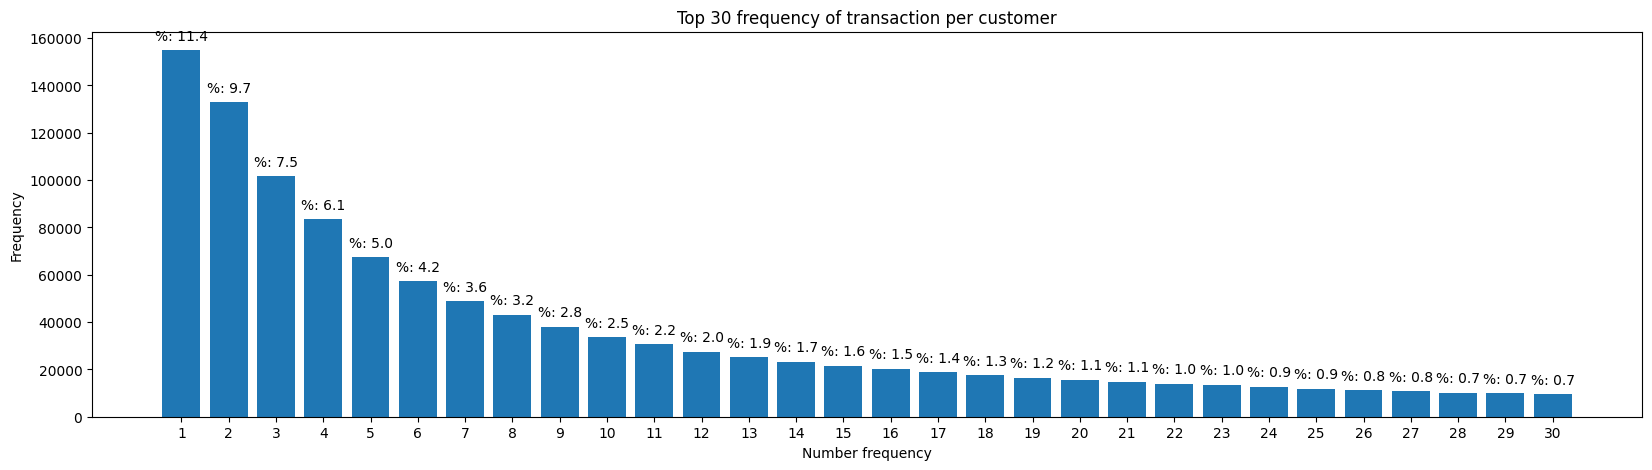

In [5]:
# Total number of transaction per customer. Customer with 1 or 3 transaction  or purchase less the 3 item, might will not help. 
# But we need to consider the transaction date in different date. As it is possible that customer has purchase more then 1 item in same date
hlpeda.plot_frequency(train_tran, "customer_id", 30, "transaction per customer")

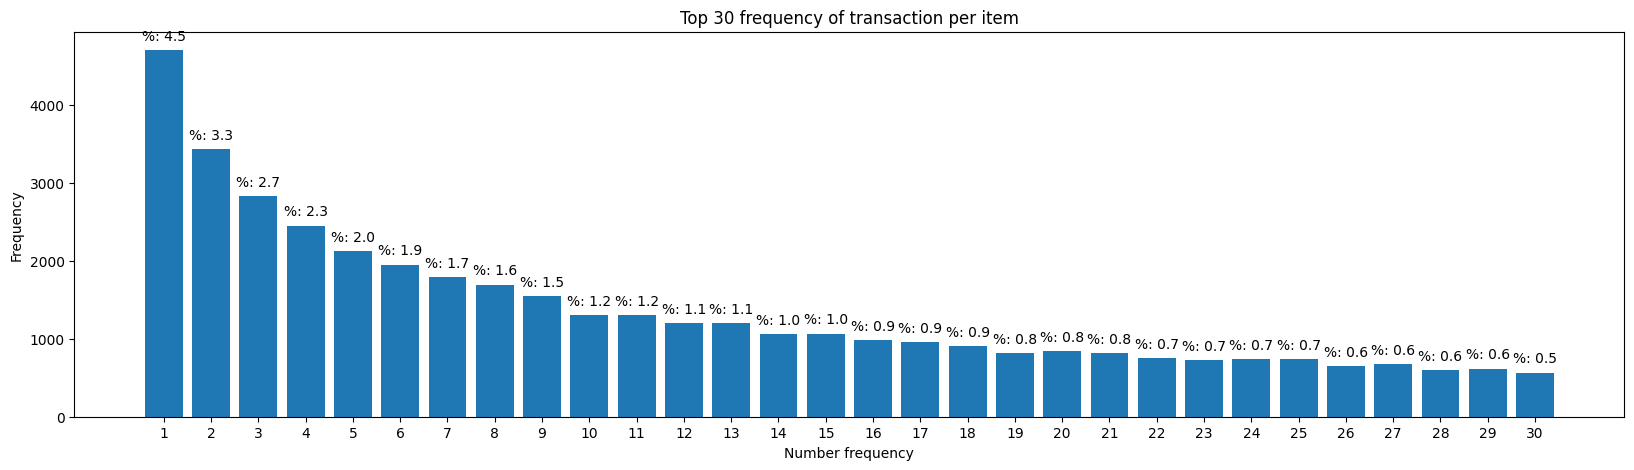

In [7]:
hlpeda.plot_frequency(train_tran, "article_id", 30, "transaction per item")

**Observartion:**
* 11.4% of users have mave purchase only one item till date. i.e only one transaction till date.
* 88.6% of users have purchase more then one item either on same date (i.e single transaction) or different date.
* 4.5% of items have been purchase only once. But it is possible that those items where purchase by different user. So lets keep those for now.

**So user who has purchase one item till date we can drop those as we will not be able to understand there preference. But lets keep the customer that has purchase one item in last weeks as it mosly like they could purchase next week based on the experience with the resent purchase.**<br/>
**Which last week to consider is based on the average days for users next transaction?**

### **Question**: ###
#### 1. What is the average number of days elapsed since user's previous purchase? ####
#### 2. What is an number of item a user purchase per transaction? ####
#### 3. Total transaction made by user? ####

##### It will help to: #####
1. understand user's purchase pattern.
2. discard transaction where user have purchase only one item till date, by considering only those transaction that are within the average number of days for next transaction of such users.

***Note***: *User with multiple item purchase on same date can be thought of item purchase in single cart add.*

In [7]:
#Steps: Calculate average number of days elapsed for any user's next transaction  
# 1. Count number of items purchase per transaction 
# 2. Calculate number of days pass after the first transaction

#Count number of items purchase per transaction 
grp_user_tran = (train_tran[['customer_id','t_dat']]
                 .groupby(['customer_id','t_dat'])['t_dat']
                 .count()
                 .reset_index(name = "items_per_tran")
                 .sort_values(by = ['customer_id','t_dat'], 
                              ascending = True)
                )

#Calculate number of days pass after each transaction user made
grp_user_tran['previous_purchase'] = grp_user_tran.groupby('customer_id')['t_dat'].shift(periods = 1)
grp_user_tran['previous_purchase'] = pd.to_datetime(grp_user_tran['previous_purchase'], errors = 'coerce')
grp_user_tran['days_pass_since_last_purchase'] = ((grp_user_tran['t_dat'] - grp_user_tran['previous_purchase']).dt.days).fillna(0).astype(int)


grp_user_time_elpased = grp_user_tran.groupby('customer_id').agg( total_no_items_purchased = ('items_per_tran', 'sum'), 
                                                                  avg_elapse_days_per_tran = ('days_pass_since_last_purchase', 'mean'),
                                                                  #number_of_user_tran = ('customer_id', 'size') #Incorrect result. Output was sae as total_no_item, We need number of tran user made till data
                                                                  number_of_user_tran = ('t_dat', 'count')
                                                                  ).reset_index()   

display(grp_user_time_elpased)

global_avg_elapse_days = grp_user_time_elpased['avg_elapse_days_per_tran'].mean()


grp_user_tran = pd.merge(grp_user_tran, grp_user_time_elpased, how='inner',on = 'customer_id')
print('='*150)
display(grp_user_tran)

del [grp_user_time_elpased]
gc.collect()

,customer_id,total_no_items_purchased,avg_elapse_days_per_tran,number_of_user_tran
0,-9223352921020755230,10,96.285714,7
1,-9223343869995384291,134,12.288136,59
2,-9223321797620987725,2,0.000000,1
3,-9223319430705797669,8,0.000000,1
4,-9223308614576639426,1,0.000000,1
...,...,...,...,...
1362276,9223319300843860958,2,4.500000,2
1362277,9223333063893176977,4,38.000000,2
1362278,9223345314868180224,10,0.000000,1
1362279,9223357421094039679,6,18.000000,3


,customer_id,t_dat,items_per_tran,previous_purchase,days_pass_since_last_purchase,total_no_items_purchased,avg_elapse_days_per_tran,number_of_user_tran
0,-9223352921020755230,2018-10-30,2,NaT,0,10,96.285714,7
1,-9223352921020755230,2019-07-28,1,2018-10-30,271,10,96.285714,7
2,-9223352921020755230,2019-09-27,1,2019-07-28,61,10,96.285714,7
3,-9223352921020755230,2019-10-26,1,2019-09-27,29,10,96.285714,7
4,-9223352921020755230,2019-11-29,1,2019-10-26,34,10,96.285714,7
...,...,...,...,...,...,...,...,...
8877451,9223345314868180224,2018-10-02,10,NaT,0,10,0.000000,1
8877452,9223357421094039679,2019-02-22,3,NaT,0,6,18.000000,3
8877453,9223357421094039679,2019-03-20,2,2019-02-22,26,6,18.000000,3
8877454,9223357421094039679,2019-04-17,1,2019-03-20,28,6,18.000000,3


19

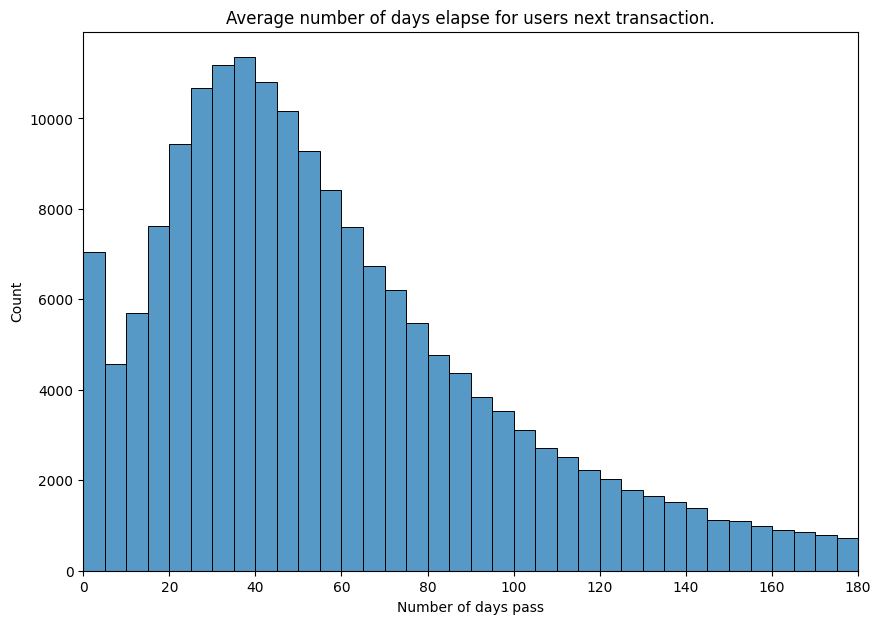

In [8]:
fig = plt.figure(figsize = (10,7))
ax = sns.histplot(data = (grp_user_tran[['customer_id','avg_elapse_days_per_tran']]
                          .drop_duplicates(keep = 'first')
                          #remove where user's has purchase only once or there first purchase
                          .query('avg_elapse_days_per_tran > 0')),
                  x = 'avg_elapse_days_per_tran',                 
                  bins = 18,
                  stat = 'frequency',
                  binwidth = 5,
                  binrange = (0,365)
                  )

ax.set_title("Average number of days elapse for users next transaction.")
ax.set_xlabel("Number of days pass")
ax.set_ylabel("Count")
ax.set_xlim(0,180)
plt.show()

**Observartion:**
1. On an average user's make a new transaction between 10-50 days after there last purchase.

**Note:**
*  Will can check the performance of model with and without droping single transaction of user, as even one transaction it might help better understand the popalarity of the items the user has purchase. By droping those records will lose information on such products. E.g if 10 different user has brought only one "Item A" till date. But there are other 5 user how has brought "Item A" but they have purchase other items purchase as well. By removing those 10 user's transaction data we might lose valuable information about the populatity of "Item A". So lets count total purchase of all items and the various price at which items where sold.

Global average elapsed days: 42.88517504145585
Total number of records: 35463, number of items that where sold less or equal to 10 units: 3705
------------------------------Top 10 records------------------------------


,single_tran_by_user_false,single_tran_by_user_true,items_total_tran
article_id,,,
568601006,14742,416,15158
706016001,31930,321,32251
661794001,3364,282,3646
720125001,17389,222,17611
673396002,16936,211,17147
661794002,2396,204,2600
706016002,25287,198,25485
759465001,8347,178,8525
639448001,3609,172,3781


------------------------------Bottom 10 records------------------------------


,single_tran_by_user_false,single_tran_by_user_true,items_total_tran
article_id,,,
763196001,317,1,318
763196002,274,1,275
763208001,35,1,36
763208004,24,1,25
572955016,111,1,112
678963016,550,1,551
518978001,59,1,60
518806003,19,1,20
763275001,1477,1,1478


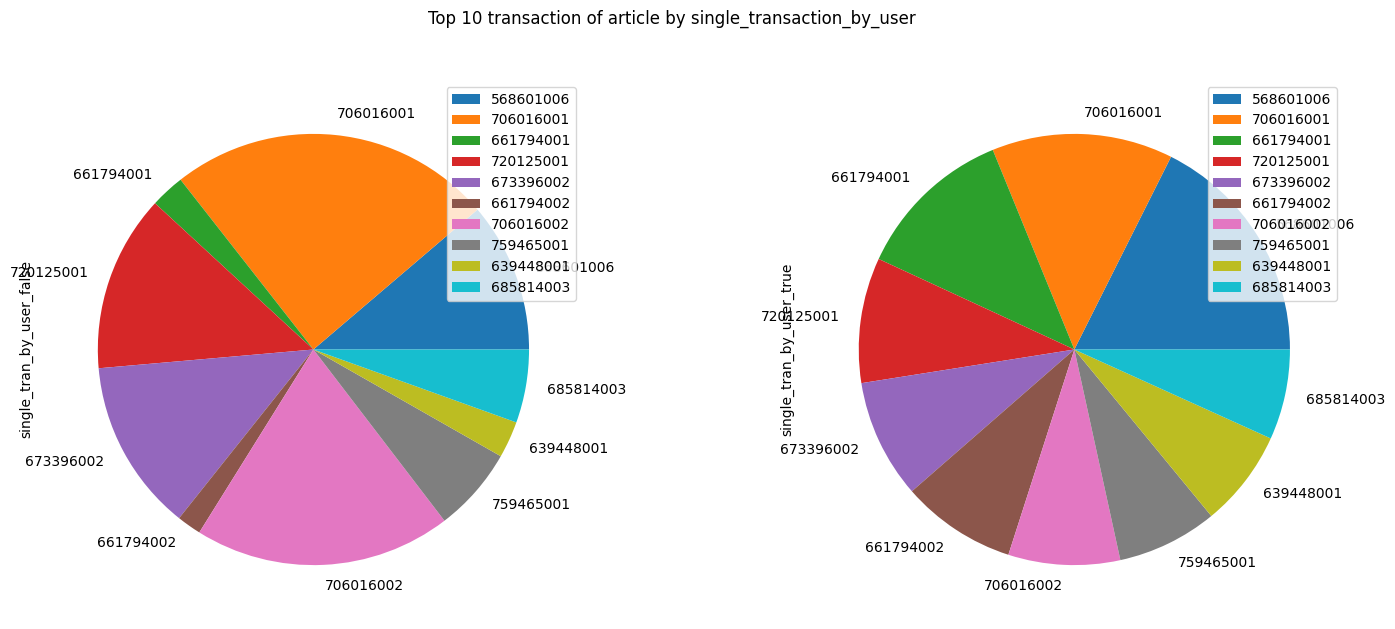

In [9]:
# Marks the transaction of user where only one transaction was made by user. But keep the transaction made based on the global average elapse days 
# This will help use to understand the effect of removal of these records on the overall of items purchase count with single user transaction. 
print(f"Global average elapsed days: {global_avg_elapse_days}")
last_tran_date_record = train_tran.t_dat.max()
train_tran['single_tran_by_user'] = (train_tran.customer_id
                                     .isin((grp_user_tran[(grp_user_tran.total_no_items_purchased == 1) & 
                                                          (grp_user_tran.t_dat < (last_tran_date_record - timedelta(days = global_avg_elapse_days)))
                                                         ].customer_id)))

single_tran_items = train_tran[train_tran.article_id.isin(train_tran[train_tran.single_tran_by_user].article_id)]

#Of Total transaction made for an item how many are by user's which was there only transaction vs user's made other transaction
pvt_output = pd.pivot_table(data = single_tran_items, 
                            index = ['article_id'], 
                            columns = ['single_tran_by_user'], 
                            values = 'customer_id',#'product_code',
                            aggfunc = 'count',
                            fill_value = 0,
                            margins = True, margins_name = 'Total',
                            sort = True)

pvt_output.drop(index = ['Total'], inplace = True) #Drop row with index 'Total'
pvt_output.columns = ['single_tran_by_user_false', 'single_tran_by_user_true', 'items_total_tran']
pvt_output.sort_values(by = 'single_tran_by_user_true', ascending = False, inplace = True )
#pvt_output.sort_values(by = 'Total', ascending = False, inplace = True )

#pvt_output[pvt_output.Total == 1]
threshold = 10
single_tran_items_cnt = pvt_output[pvt_output.items_total_tran <= threshold].items_total_tran.sum()
print(f'Total number of records: {pvt_output.shape[0]}, number of items that where sold less or equal to {threshold} units: {single_tran_items_cnt}')
      
#Filter out the items with only one tran
#pvt_output = pvt_output[pvt_output.Total > 1]

#Top n article where sales by customer
n = 10
print("-"*30 + "Top " + str(n) + " records" + "-"*30)
display(pvt_output[:n])

(pvt_output[['single_tran_by_user_false', 'single_tran_by_user_true']][:n]
 .plot
 .pie(subplots = True, 
      figsize = (18,7), 
      sharex = True, 
      title = 'Top {0} transaction of article by single_transaction_by_user'.format(str(n))
     )
)

print("-"*30 + "Bottom " + str(n) + " records" + "-"*30)
display(pvt_output[-n:])

#pvt_output.single_tran_user_true.unique()

In [ ]:
#Top items
if hlpimage.SHOW_ITEMS_IMAGE == True:
    hlpimage.show_item_img(pvt_output[:15].index)

In [ ]:
#Botton n items based on the sold counts
if hlpimage.SHOW_ITEMS_IMAGE == True:
    hlpimage.show_item_img(pvt_output[-15:].index)

In [10]:
del [pvt_output]
gc.collect()

8176

**Observartion**:

1. Those single transaction by user contribute to approx 10%-2% to overall purchase of items. Items where trousers, accessories, and tops. 
2. Items which least transaction are similar item but not purchase frequenlty. 

So even if we remove those it will not be impacting the overall popalarity of such items

In [11]:
#Filter out records where single transaction by user is false. 
print(f'Shape of transaction records before removing single transaction by user: {train_tran.shape}')

train_tran = train_tran[train_tran.single_tran_by_user ==  False]

print(f'Shape of transaction records after removing single transaction by user: {train_tran.shape}')

Shape of transaction records before removing single transaction by user: (27306439, 6)
Shape of transaction records after removing single transaction by user: (27161318, 6)


### **Question**: Which product_types has maximim sales? ###

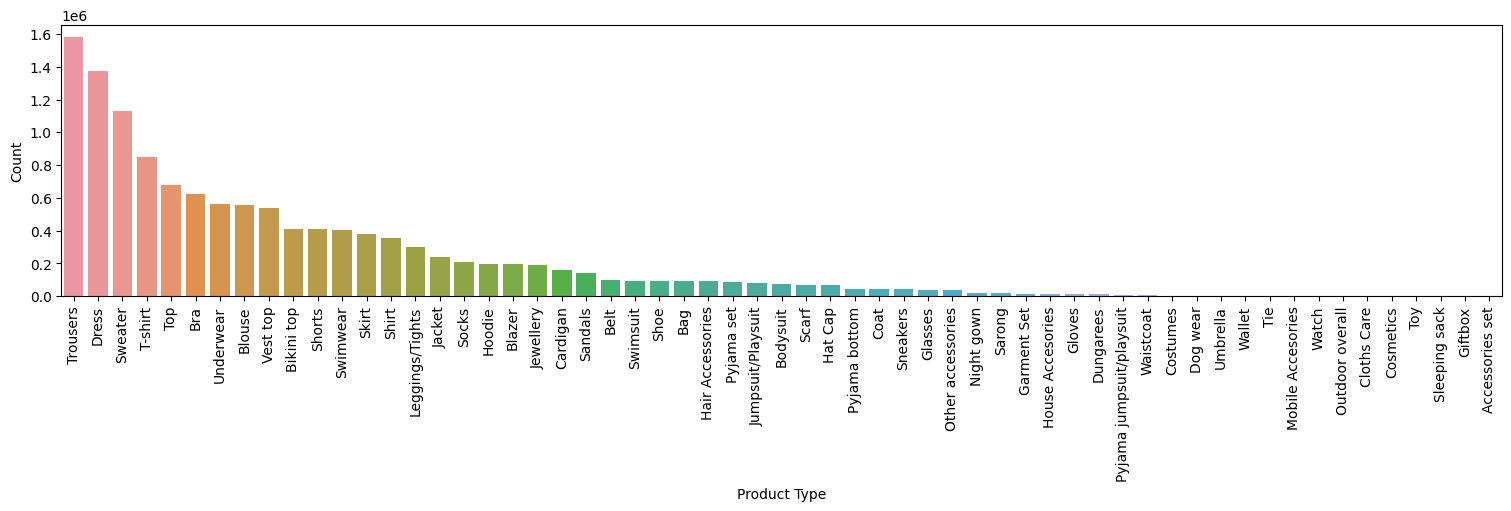

In [10]:
fig_WS = plt.figure(num = 1, 
                    figsize = (15,5), 
                    dpi = 100, 
                    clear = True,
                    constrained_layout =  True
                    )

ax = sns.countplot(data = train_tran, 
                   x = 'product_type_name',
                   order = train_tran['product_type_name'].value_counts().index
                   )

ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation = 90                   
                   )

ax.set_xlabel("Product Type")
ax.set_ylabel("Count")

plt.show()
fig_WS.clf()

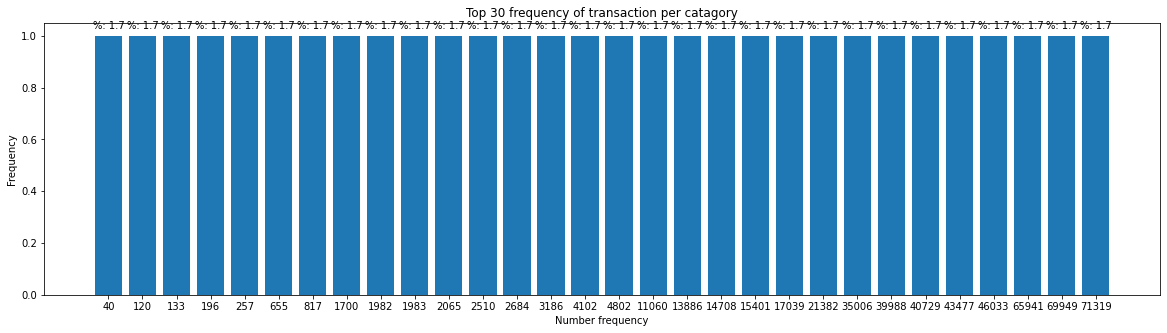

In [11]:
hlpeda.plot_frequency(train_tran, "product_type_name", 30, "transaction per catagory")

***Observation*:**
1. Top 5 catagory of products that are sold are Trousers, Dress, Sweater, T-Shirt, Top and Bar.
2. There are 0 product type that has only appeared once. All product type have many observations and can be leveraged for prediction. 
3. Some categorical features (categories) have high occurances

### **Question**: What product type are sold in last 6 weeks? Are there specific type i.e graphical appearance name of trouse, dress, sweaters that are sold? ###

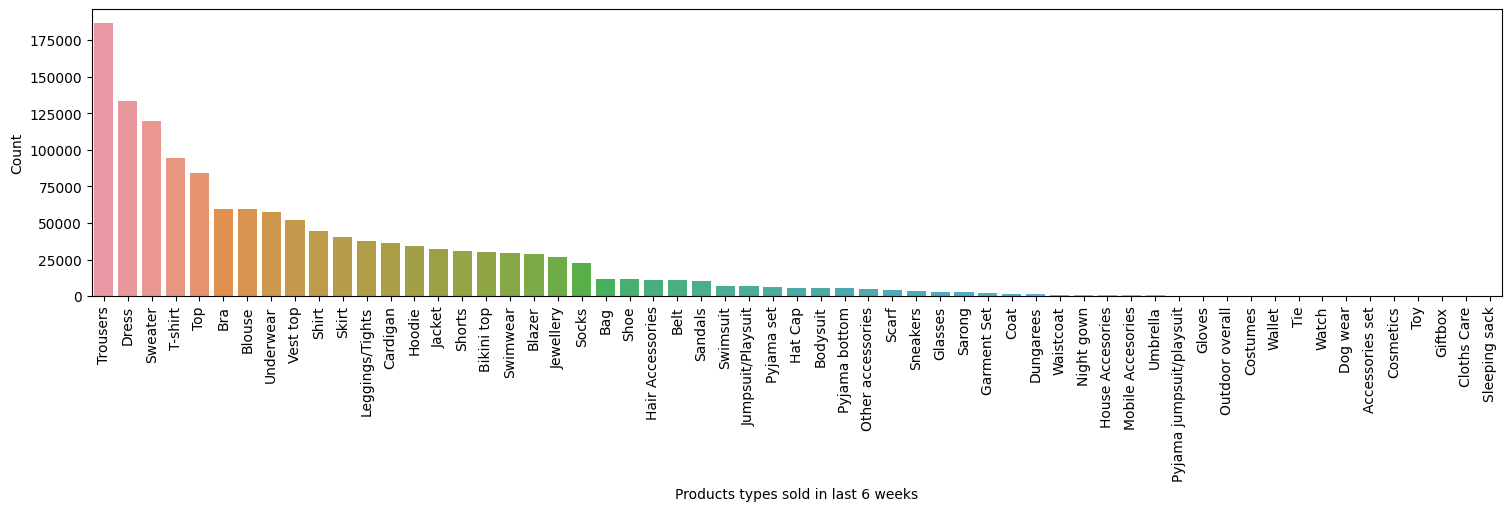

In [12]:
#Get last 6 week transaction records
last_6week_tran = train_tran[train_tran.t_dat >= (last_tran_date_record - timedelta(weeks = 6))]
         
#Plot which product_type has been sold in last 6 weeks
fig_WS = plt.figure(num = 1, 
                    figsize = (15,5), 
                    dpi = 100, 
                    clear = True,
                    constrained_layout =  True
                    )

ax = sns.countplot(data = last_6week_tran, 
                   x = 'product_type_name',
                   order = last_6week_tran['product_type_name'].value_counts().index
                   )

ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation = 90                   
                   )

ax.set_xlabel("Products types sold in last 6 weeks")
ax.set_ylabel("Count")

plt.show()
fig_WS.clf()

In [13]:
last_6week_tran.head()

,article_id,t_dat,customer_id,price,online_sale,product_code,prod_name,product_type_no,product_type_name,product_group_name,...,index_group_name,garment_group_no,garment_group_name,product_type_name_org,clean_product_type_name,clean_product_group_name,clean_index_group_name,clean_index_name,clean_department_name,single_tran_by_user
9596950,816423004,2020-08-07,1364919916846399450,0.022860,True,816423,Ozzy HW Denim Shorts,274,Shorts,Garment Lower body,...,Divided,1025,Shorts,Shorts,Shorts,Garment Lower body,Divided,Divided,Shorts,False
9817343,836607002,2020-08-07,-7825025505146043022,0.006763,False,836607,Alma Linnen Mix Scarf,80,Scarf,Accessories,...,Ladieswear,1019,Accessories,Scarf,Scarf,Accessories,Ladieswear,Ladies Accessories,Scarves,False
8702916,843533002,2020-08-07,-7717789474063157216,0.011850,True,843533,Joey HW Straight Utilaty TRS,272,Trousers,Garment Lower body,...,Divided,1009,Trousers,Trousers,Trousers,Garment Lower body,Divided,Divided,Trousers,False
11791611,817417005,2020-08-07,3333216941928775728,0.016940,False,817417,Khloe,274,Shorts,Garment Lower body,...,Ladieswear,1025,Shorts,Shorts,Shorts,Garment Lower body,Ladieswear,Ladieswear,Shorts,False
11788523,866457006,2020-08-07,7521639634934012860,0.027100,True,866457,Billie dress,265,Dress,Garment Full body,...,Ladieswear,1013,Dresses Ladies,Dress,Dress,Garment Full body,Ladieswear,Ladieswear,Dress,False


In [14]:
#Plot top n items/articles that are sold highest by type
n = 20
last_6week_tran = (last_6week_tran
                   .groupby(['product_type_name','article_id'])['article_id']
                   .count()
                   .reset_index(name ="count")
                   #.sort_values(by = 'count', ascending = False) #Since after merge had to sort again to keep the top items by count at first. As after merge sorted order was not maintain
                   )
#last_6week_tran

#Since we only need the article_id we can drop the all the other tran on the article_id and keep only the first.
#Bellow code get the details(atribute) of the items from the main train_tran
col = ['article_id','product_type_name','product_group_name', 
       'graphical_appearance_name','garment_group_name',
       'index_group_name', 'index_name',
       'department_name'
      ]
atribute = train_tran[train_tran.article_id.isin(last_6week_tran.article_id)][col].drop_duplicates(keep = 'first')

last_6week_tran = last_6week_tran.merge(atribute, how = 'inner', on = ['article_id','product_type_name'])
last_6week_tran.sort_values(by = 'count', ascending = False, inplace = True)

del [atribute]
gc.collect()

15550

In [15]:
#Top n items/articles that are sold higest
display(last_6week_tran[:n])

if hlpimage.SHOW_ITEMS_IMAGE == True:
    hlpimage.show_item_img(last_6week_tran[:n].article_id)

,product_type_name,article_id,count,product_group_name,graphical_appearance_name,garment_group_name,index_group_name,index_name,department_name
13396,Leggings/Tights,918292001,2629,Garment Lower body,Melange,Jersey Fancy,Sport,Sport,Ladies Sport Bottoms
27634,Trousers,751471001,2606,Garment Lower body,Solid,Trousers,Ladieswear,Ladieswear,Trouser
4316,Cardigan,916468003,2449,Garment Upper body,Solid,Knitwear,Ladieswear,Ladieswear,Knitwear
21885,Sweater,915526001,2419,Garment Upper body,Solid,Knitwear,Ladieswear,Ladieswear,Knitwear
24619,T-shirt,896152002,2245,Garment Upper body,Solid,Knitwear,Ladieswear,Ladieswear,Knitwear
...,...,...,...,...,...,...,...,...,...
13319,Leggings/Tights,866731001,1531,Garment Lower body,Solid,Jersey Fancy,Sport,Sport,Ladies Sport Bottoms
27211,Trousers,714790020,1526,Garment Lower body,Denim,Trousers Denim,Divided,Divided,Denim Trousers
25763,Top,865929003,1524,Garment Upper body,All over pattern,Jersey Fancy,Ladieswear,Ladieswear,Jersey Fancy
4283,Cardigan,896169002,1482,Garment Upper body,Melange,Knitwear,Ladieswear,Ladieswear,Knitwear


In [16]:
#Bottom n items/articles that are sold least
display(last_6week_tran[-n:])

if hlpimage.SHOW_ITEMS_IMAGE == True:
    hlpimage.show_item_img(last_6week_tran[-n:].article_id)

,product_type_name,article_id,count,product_group_name,graphical_appearance_name,garment_group_name,index_group_name,index_name,department_name
15365,Shirt,749848001,1,Garment Upper body,Solid,Shirts,Baby/Children,Children Sizes 134-170,Young Boy Shirt
15366,Shirt,749848010,1,Garment Upper body,All over pattern,Shirts,Baby/Children,Children Sizes 134-170,Young Boy Shirt
15372,Shirt,750648002,1,Garment Upper body,Solid,Shirts,Menswear,Menswear,Shirt
27076,Trousers,702159001,1,Garment Lower body,Solid,Trousers,Ladieswear,Ladieswear,Trouser
15375,Shirt,750694001,1,Garment Upper body,Solid,Shirts,Menswear,Menswear,Shirt
...,...,...,...,...,...,...,...,...,...
15394,Shirt,755713003,1,Garment Upper body,All over pattern,Shirts,Baby/Children,Children Sizes 92-140,Kids Boy Shirt
15396,Shirt,758805001,1,Garment Upper body,Solid,Shirts,Baby/Children,Children Sizes 92-140,Kids Boy Shirt
15403,Shirt,762846010,1,Garment Upper body,Solid,Blouses,Ladieswear,Ladieswear,Blouse
15410,Shirt,762853002,1,Garment Upper body,Other structure,Shirts,Menswear,Menswear,Shirt


**Observartion:**
 
1. There is no relationship between type of graphical apperance of the items that are sold in last 6 weeks
2. Of top n article are items that belong to Garment Upper body and Lower body segement.

### **Question**: Is there any relation between subscription of customer and transaction that user make ###

In [19]:
#df_user_feature = pd.read_pickle(consts.USER_FEATURE_V1, compression = 'gzip')

df_user_feature = df_user_feature[['customer_id','total_no_items_purchased',
                'avg_elapse_days_per_tran', 'number_of_user_tran',
                'global_avg_elapse_days']].drop_duplicates()

df_user_feature = df_user_feature.merge(df_customer[['customer_id','subscribe_fashion_newsletter']], on = 'customer_id', how = 'inner')

df_user_feature.sort_values(by = 'total_no_items_purchased', ascending = False, inplace = True)

print(f'Shape {df_user_feature.shape}')
display(df_user_feature.head())

Shape (1362281, 6)


,customer_id,total_no_items_purchased,avg_elapse_days_per_tran,number_of_user_tran,global_avg_elapse_days,subscribe_fashion_newsletter
1114428,5854009424779598107,1346,2.585714,280,42.885175,False
782091,1362310019195253974,1121,2.947368,247,42.885175,True
736531,742206143892321423,1088,2.951613,248,42.885175,False
1227898,7398229172292340849,1068,3.203540,226,42.885175,True
345554,-4557035136527070563,972,12.396552,58,42.885175,False


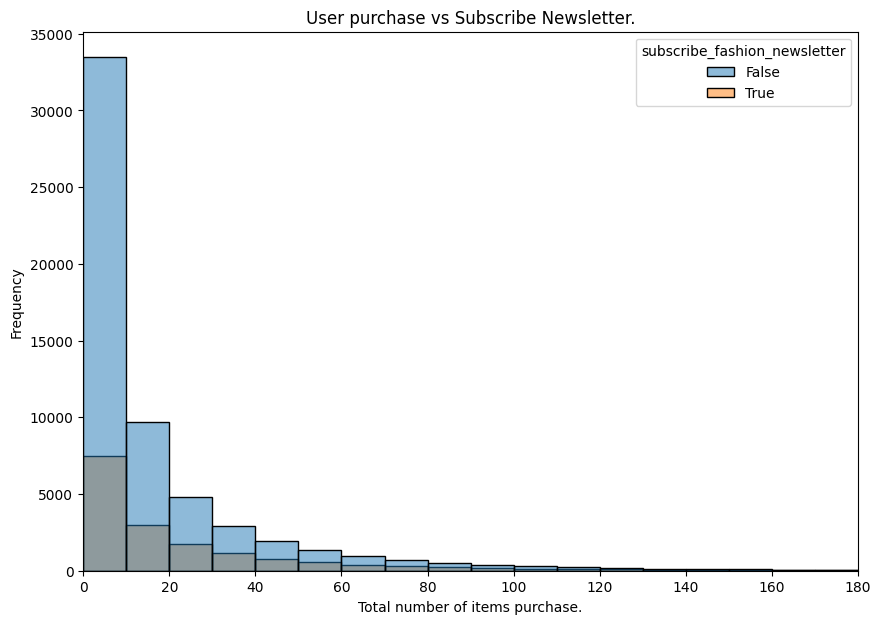

In [20]:

fig = plt.figure(figsize = (10,7))
ax = sns.histplot(data = df_user_feature,
                  x = 'total_no_items_purchased',                 
                  bins = 18,
                  stat = 'frequency',
                  binwidth = 10,
                  binrange = (0,180),
                  hue = 'subscribe_fashion_newsletter'
                  )
ax.set_title("User purchase vs Subscribe Newsletter.")
ax.set_xlabel("Total number of items purchase.")
ax.set_ylabel("Frequency")
ax.set_xlim(0,180)
plt.show()

**Observartion**:
There is no relation ship between subscribe of fashion newsletter to number of item user purchase since non-subscribed user have purchase much more compare to subscribed user's.

***Lets drop the feature 'subscribe_fashion_newsletter' from the user_feature tables***

In [21]:
#Drop column/feature 'subscribe_fashion_newsletter' from df_user_feature
df_user_feature.drop(['subscribe_fashion_newsletter'], axis = 1, inplace = True)
#df_user_feature.columns

### **Question**: Are there any user that only make purchase in Online/Offline? ###
**Answer:** *It does not matter as even if the user's purchase offline if there are similar user's like her/him in online we can recommend the items user's purchase offline to user's purchase in online.*

### **Question**: Are there user who always buy same type of product? ###

* Like they buy Tops or Trouses. This will give preference of an user. So we shall count the number of different type the user has purchase.
* We should consider the recent preference of the user and not over all
* We shall see the user purchase over last 6 weeks or average elapsed duration of any user, with previous purchase that could be help full

***Idea is***: *Thought process here is first we shoud understand what type of the product_type user's generally purchase from the platform. This will help use understand which other items in same product_type can we should recommmend.
**e.g** when we go for shopping at store the shopkeeper asked us which type of clothes do we want to see like dress, pants etc and then shopkeeper start showing the differnet variety of garment under that product type.
Similary here want to understand the user who make a frequent purchase, which type of the product they usually purchase and recommend should show different option, based on there previous purchase in the same type.*

**For this**: *We can create a column for user based on there type i.e we can create column for each product type and specify number of items user has purchase for that type. This can help what is there overall preference also added  column to for product count for user last 6 week which will help to understand the current user preference.*

In [6]:
#We have transaction of article which we have removed during cleaning process. product type will be nan for such transaction.
train_tran = train_tran.merge(df_article[['article_id','product_type_name','clean_product_type_name']], on = 'article_id', how = 'left')
train_tran.shape

(27161318, 8)

In [14]:
#train_tran[train_tran.product_type_name.isna()].article_id
train_tran.product_type_name.isna().sum()

112211

In [8]:

unique_product_type = train_tran.clean_product_type_name.unique()
unique_product_type

array(['Bra', 'Sweater', 'Blouse', 'Trousers', 'Cardigan', 'Vest top',
       'Skirt', 'T shirt', 'Top', 'Belt', 'Socks', 'Shoe',
       'Other accessories', 'Hair Accessories', 'Dress',
       'Pyjama jumpsuit playsuit', 'Shirt', 'Pyjama set', 'Bag',
       'Jewellery', 'Underwear', 'Jacket', 'Costumes', 'Hoodie', 'Scarf',
       'Bodysuit', 'Jumpsuit Playsuit', 'Leggings Tights', 'Coat',
       'Sandals', 'Blazer', 'Swimsuit', 'Bikini top', 'Swimwear',
       'Hat Cap', 'Cosmetics', 'Waistcoat', nan, 'Shorts', 'Watch',
       'Gloves', 'House Accesories', 'Pyjama bottom', 'Glasses', 'Tie',
       'Dungarees', 'Garment Set', 'Umbrella', 'Night gown', 'Toy',
       'Sarong', 'Outdoor overall', 'Sleeping sack', 'Wallet', 'Giftbox',
       'Dog wear', 'Accessories set', 'Cloths Care', 'Mobile Accesories'],
      dtype=object)

**Note**: *Since product_type_name is highly cardinal it will be difficult to understand the pattern. So based on the early EDA lets group the product as "Other" that are not sold frequently.*

In [9]:
#Call the function with a default threshold of 85%
#Reduce Catanality: https://towardsdatascience.com/dealing-with-features-that-have-high-cardinality-1c9212d7ff1b
train_tran['new_product_type_name'], new_category_list = hlpeda.cumulatively_categorise(train_tran.clean_product_type_name, 
                                                                                    threshold = 0.85, 
                                                                                    return_categories_list = True)

print(f'Number of original product types: {len(unique_product_type)}\nNumber of new product type: {len(new_category_list)}\nNew category list: {new_category_list}')

Number of original product types: 59
Number of new product type: 20
New category list: ['Trousers', 'Dress', 'Sweater', 'T shirt', 'Top', 'Blouse', 'Vest top', 'Bra', 'Underwear', 'Shorts', 'Bikini top', 'Swimwear', 'Skirt', 'Shirt', 'Leggings Tights', 'Jacket', 'Hoodie', 'Socks', 'Jewellery', 'Other']


In [10]:
#method will calculate the % of the type it contribute to overall purchase of the user
def ctb_type_pct(df, new_col_name):
    pvt_output = pd.pivot_table(data = df, 
                                index = ['customer_id'], 
                                columns = ['new_product_type_name'], 
                                values = 'article_id',
                                aggfunc = 'count',
                                fill_value = 0,
                                margins = True, margins_name = 'Total',
                                #sort = True #Sort is an expensive operation
                                )

    pvt_output.drop(index = ['Total'], inplace = True) #Drop row with index 'Total'
    #pvt_output.sort_values(by = 'Total', ascending = False, inplace = True ) #Sort is an expensive operation
    #pvt_output

    #What % of there overall user purchase does the items type contribute of user transaction
    for col in pvt_output.columns:
        if col != 'Total':
            pvt_output[col] = round(pvt_output[col]/pvt_output['Total'],2) #len(new_category_list)
    #pvt_output

    #Transform the data from wide to long
    pvt_output = pd.melt(pvt_output.reset_index(level = 0), 
                         id_vars = 'customer_id', 
                         value_vars = new_category_list)
    
    #pct_items_ctb_last_6week: stands for percentage(pct) of the product type contribution(ctb) in the total purchase made by the user in last 6 week/overall of data
    pvt_output.columns = ['customer_id','new_product_type_name', new_col_name] #'pct_type_ctb_last_6week'
    pvt_output = pvt_output[pvt_output[new_col_name] > 0]
    #pvt_output.sort_values(by = 'value', ascending = False, inplace = True)
    #pvt_output
    
    return pvt_output
    

In [19]:
last_tran_date_record = train_tran.t_dat.max() 
#avg_elapse_days = 42 #6 weeks. 7*6 = 42
#avg_elapse_days = 27.346172257865398 # df_user_feature['avg_elapse_days'] #Average elapse days 

last_8week_tran = train_tran[train_tran.t_dat >= (last_tran_date_record - timedelta(weeks = 8))]
pvt_output = ctb_type_pct(last_8week_tran,'pct_type_ctb_last_8week')

#Merge the result to main train dataframe
train_tran = (train_tran
              .set_index(['customer_id','new_product_type_name'])
              .join(pvt_output.set_index(['customer_id','new_product_type_name']),
                    on = ['customer_id','new_product_type_name'])
              .reset_index())

In [20]:
#Over all % of the type 
pvt_output = ctb_type_pct(train_tran,'pct_type_ctb')

#Merge the result to main train dataframe
train_tran = (train_tran
              .set_index(['customer_id','new_product_type_name'])
              .join(pvt_output.set_index(['customer_id','new_product_type_name']),
                    on = ['customer_id','new_product_type_name'])
             .reset_index()
             )
train_tran['pct_type_ctb_last_8week'].fillna(value = 0, inplace = True)

In [22]:
train_tran[train_tran.customer_id == 5854009424779598107][['customer_id', 'clean_product_type_name', 'article_id',  'pct_type_ctb_last_8week', 'pct_type_ctb']]

,customer_id,clean_product_type_name,article_id,pct_type_ctb_last_8week,pct_type_ctb
92084,5854009424779598107,Sweater,685687001,0.11,0.10
92085,5854009424779598107,Trousers,478549001,0.06,0.12
92086,5854009424779598107,Sweater,670655001,0.11,0.10
244861,5854009424779598107,Sweater,637515005,0.11,0.10
244862,5854009424779598107,Socks,682813002,0.01,0.01
...,...,...,...,...,...
26075498,5854009424779598107,Shorts,396135008,0.01,0.04
26075499,5854009424779598107,Shorts,396135007,0.01,0.04
26075500,5854009424779598107,Bra,253448001,0.03,0.04
26075501,5854009424779598107,Leggings Tights,241412052,0.03,0.03


In [23]:
train_tran.shape

(27161318, 11)

In [28]:
train_tran.columns

Index(['customer_id', 'new_product_type_name', 't_dat', 'article_id', 'price',
       'online_sale', 'single_tran_by_user', 'product_type_name',
       'clean_product_type_name', 'pct_type_ctb_last_8week', 'pct_type_ctb'],
      dtype='object')

In [27]:
train_tran.head()

,customer_id,new_product_type_name,t_dat,article_id,price,online_sale,single_tran_by_user,product_type_name,clean_product_type_name,pct_type_ctb_last_8week,pct_type_ctb
0,-6846340800584936,Bra,2018-09-20,541518023,0.030487,True,False,Bra,Bra,0.0,0.07
1,-8334631767138808638,Sweater,2018-09-20,505221004,0.015236,True,False,Sweater,Sweater,0.0,0.05
2,-8334631767138808638,Sweater,2018-09-20,685687003,0.016937,True,False,Sweater,Sweater,0.0,0.05
3,-8334631767138808638,Sweater,2018-09-20,685687004,0.016937,True,False,Sweater,Sweater,0.0,0.05
4,-8334631767138808638,Sweater,2018-09-20,685687001,0.016937,True,False,Sweater,Sweater,0.0,0.05


In [36]:
df_article.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc',
       'product_type_name_org', 'clean_product_type_name',
       'clean_product_group_name', 'clean_index_group_name',
       'clean_index_name', 'clean_department_name', 'is_item_image_missing'],
      dtype='object')

In [38]:
#Copy the new product type back to article master data table
df_article = df_article.merge(train_tran[['clean_product_type_name','new_product_type_name']].drop_duplicates(),
                                on = 'clean_product_type_name',
                                how = 'left')


In [40]:
df_article.new_product_type_name.isna().sum()

0

In [41]:
#Save the Version 2 of article id
df_article.to_pickle(consts.CLEAN_ARTICLES_MASTER_TABLE_V2, compression = 'gzip' , protocol = 4)
del df_article
gc.collect()

In [43]:
#Save the percentage infromation about the user purchase to seperate file based on the product type
df_User_feature_v2 = train_tran[['customer_id','new_product_type_name','pct_type_ctb_last_8week', 'pct_type_ctb']].drop_duplicates()
df_User_feature_v2.rename(columns = {'new_product_type_name': 'product_type_name'}, inplace = True)
display(df_User_feature_v2.head())


del df_User_feature_v2
gc.collect()


,customer_id,product_type_name,pct_type_ctb_last_8week,pct_type_ctb
0,-6846340800584936,Bra,0.00,0.07
1,-8334631767138808638,Sweater,0.00,0.05
6,3618040643253904000,Blouse,0.00,0.13
7,3618040643253904000,Trousers,0.00,0.13
11,8486166240428812738,Other,0.29,0.19


### **Question**: Find user who have similary purchase type in last 8 weeks? ### 

### **Scale price feature for futher analysis** ###

**Randomly selected few items and checked there price for indian market and take the mean/mode of the scaled price that aprox the price in the transaction data**

<table border="1">
<tbody>
<tr>
<td style="width: 55.2656px;">Website Sale(A)</td>
<td style="width: 55.2344px;">Website Actual(B)</td>
<td style="width: 87.8906px;">Datatable Price(C)</td>
<td style="width: 119.156px;">Is item available</td>
<td style="width: 82.7969px;">Item/Article ID</td>
<td style="width: 58.5px;">B/C</td>
<td style="width: 58.5px;">A/C</td>
<td style="width: 102.469px;">B*55300</td>
<td style="width: 76.1875px;">A*36000</td>
</tr>
<tr>
<td style="width: 55.2656px;">399</td>
<td style="width: 55.2344px;">399</td>
<td style="width: 87.8906px;">0.005373</td>
<td style="width: 119.156px;">&nbsp;</td>
<td style="width: 82.7969px;"><a href="https://www2.hm.com/en_in/productpage.0156231001.html">156231001</a></td>
<td style="width: 58.5px;">74260.2</td>
<td style="width: 58.5px;">74260.2</td>
<td style="width: 102.469px;">297</td>
<td style="width: 76.1875px;">193.428</td>
</tr>
<tr>
<td style="width: 55.2656px;">399</td>
<td style="width: 55.2344px;">399</td>
<td style="width: 87.8906px;">0.008458</td>
<td style="width: 119.156px;">&nbsp;</td>
<td style="width: 82.7969px;"><a href="https://www2.hm.com/en_in/productpage.0717490079.html">717490079</a></td>
<td style="width: 58.5px;">47174.3</td>
<td style="width: 58.5px;">47174.3</td>
<td style="width: 102.469px;">468</td>
<td style="width: 76.1875px;">304.488</td>
</tr>
<tr>
<td style="width: 55.2656px;">1299</td>
<td style="width: 55.2344px;">1299</td>
<td style="width: 87.8906px;">0.016932</td>
<td style="width: 119.156px;">&nbsp;</td>
<td style="width: 82.7969px;"><a href="https://www2.hm.com/en_in/productpage.0743722002.html">743722002</a></td>
<td style="width: 58.5px;">76718.6</td>
<td style="width: 58.5px;">76718.6</td>
<td style="width: 102.469px;">936</td>
<td style="width: 76.1875px;">609.552</td>
</tr>
<tr>
<td style="width: 55.2656px;">1299</td>
<td style="width: 55.2344px;">1299</td>
<td style="width: 87.8906px;">0.025407</td>
<td style="width: 119.156px;">Product no longer available</td>
<td style="width: 82.7969px;"><a href="https://www2.hm.com/en_in/productpage.0865938002.html">865938002</a></td>
<td style="width: 58.5px;">51127.6</td>
<td style="width: 58.5px;">51127.6</td>
<td style="width: 102.469px;">1405</td>
<td style="width: 76.1875px;">914.652</td>
</tr>
<tr>
<td style="width: 55.2656px;">699</td>
<td style="width: 55.2344px;">1499</td>
<td style="width: 87.8906px;">0.027102</td>
<td style="width: 119.156px;">&nbsp;</td>
<td style="width: 82.7969px;"><a href="https://www2.hm.com/en_in/productpage.0660599017.html">660599017</a></td>
<td style="width: 58.5px;">55309.6</td>
<td style="width: 58.5px;">25791.5</td>
<td style="width: 102.469px;">1499</td>
<td style="width: 76.1875px;">975.672</td>
</tr>
<tr>
<td style="width: 55.2656px;">799</td>
<td style="width: 55.2344px;">1499</td>
<td style="width: 87.8906px;">0.033881</td>
<td style="width: 119.156px;">&nbsp;</td>
<td style="width: 82.7969px;"><a href="https://www2.hm.com/en_in/productpage.0826498003.html">826498003</a></td>
<td style="width: 58.5px;">44243.1</td>
<td style="width: 58.5px;">23582.5</td>
<td style="width: 102.469px;">1874</td>
<td style="width: 76.1875px;">1219.716</td>
</tr>
<tr>
<td style="width: 55.2656px;">749</td>
<td style="width: 55.2344px;">1499</td>
<td style="width: 87.8906px;">0.033881</td>
<td style="width: 119.156px;">&nbsp;</td>
<td style="width: 82.7969px;"><a href="https://www2.hm.com/en_in/productpage.0898573003.html">898573003</a></td>
<td style="width: 58.5px;">44243.1</td>
<td style="width: 58.5px;">22106.8</td>
<td style="width: 102.469px;">1874</td>
<td style="width: 76.1875px;">1219.716</td>
</tr>
<tr>
<td style="width: 55.2656px;">1299</td>
<td style="width: 55.2344px;">2699</td>
<td style="width: 87.8906px;">0.044102</td>
<td style="width: 119.156px;">&nbsp;</td>
<td style="width: 82.7969px;"><a href="https://www2.hm.com/en_in/productpage.0809230001.html">809230001</a></td>
<td style="width: 58.5px;">61199.0</td>
<td style="width: 58.5px;">29454.4</td>
<td style="width: 102.469px;">2439</td>
<td style="width: 76.1875px;">1587.672</td>
</tr>
<tr>
<td style="width: 55.2656px;">999</td>
<td style="width: 55.2344px;">2299</td>
<td style="width: 87.8906px;">0.049271</td>
<td style="width: 119.156px;">&nbsp;</td>
<td style="width: 82.7969px;"><a href="https://www2.hm.com/en_in/productpage.0793679001.html">793679001</a></td>
<td style="width: 58.5px;">46660.3</td>
<td style="width: 58.5px;">20275.6</td>
<td style="width: 102.469px;">2725</td>
<td style="width: 76.1875px;">1773.756</td>
</tr>
<tr>
<td style="width: 55.2656px;">2299</td>
<td style="width: 55.2344px;">2299</td>
<td style="width: 87.8906px;">0.050831</td>
<td style="width: 119.156px;">&nbsp;</td>
<td style="width: 82.7969px;"><a href="https://www2.hm.com/en_in/productpage.0873274002.html">873274002</a></td>
<td style="width: 58.5px;">45228.3</td>
<td style="width: 58.5px;">45228.3</td>
<td style="width: 102.469px;">2811</td>
<td style="width: 76.1875px;">1829.916</td>
</tr>
<tr>
<td style="width: 55.2656px;">1799</td>
<td style="width: 55.2344px;">2999</td>
<td style="width: 87.8906px;">0.06039</td>
<td style="width: 119.156px;">&nbsp;</td>
<td style="width: 82.7969px;"><a href="https://www2.hm.com/en_in/productpage.0848997001.html">848997001</a></td>
<td style="width: 58.5px;">49660.5</td>
<td style="width: 58.5px;">29789.7</td>
<td style="width: 102.469px;">3340</td>
<td style="width: 76.1875px;">2174.04</td>
</tr>
<tr>
<td style="width: 55.2656px;">1499</td>
<td style="width: 55.2344px;">2999</td>
<td style="width: 87.8906px;">0.06778</td>
<td style="width: 119.156px;">&nbsp;</td>
<td style="width: 82.7969px;"><a href="https://www2.hm.com/en_in/productpage.0839332001.html">839332001</a></td>
<td style="width: 58.5px;">44246.1</td>
<td style="width: 58.5px;">22115.7</td>
<td style="width: 102.469px;">3748</td>
<td style="width: 76.1875px;">2440.08</td>
</tr>
<tr>
<td style="width: 55.2656px;">1499</td>
<td style="width: 55.2344px;">2999</td>
<td style="width: 87.8906px;">0.06778</td>
<td style="width: 119.156px;">&nbsp;</td>
<td style="width: 82.7969px;"><a href="https://www2.hm.com/en_in/productpage.0839332008.html">839332008</a></td>
<td style="width: 58.5px;">44246.1</td>
<td style="width: 58.5px;">22115.7</td>
<td style="width: 102.469px;">3748</td>
<td style="width: 76.1875px;">2440.08</td>
</tr>
<tr>
<td style="width: 55.2656px;">3999</td>
<td style="width: 55.2344px;">7999</td>
<td style="width: 87.8906px;">0.095627</td>
<td style="width: 119.156px;">&nbsp;</td>
<td style="width: 82.7969px;"><a href="https://www2.hm.com/en_in/productpage.0776772001.html">776772001</a></td>
<td style="width: 58.5px;">83647.9</td>
<td style="width: 58.5px;">41818.7</td>
<td style="width: 102.469px;">5288</td>
<td style="width: 76.1875px;">3442.572</td>
</tr>
<tr>
<td style="width: 55.2656px;">2399</td>
<td style="width: 55.2344px;">7999</td>
<td style="width: 87.8906px;">0.122949</td>
<td style="width: 119.156px;">&nbsp;</td>
<td style="width: 82.7969px;"><a href="https://www2.hm.com/en_in/productpage.0788301001.html">788301001</a></td>
<td style="width: 58.5px;">65059.5</td>
<td style="width: 58.5px;">19512.2</td>
<td style="width: 102.469px;">6799</td>
<td style="width: 76.1875px;">4426.164</td>
</tr>
<tr>
<td style="width: 55.2656px;">6499</td>
<td style="width: 55.2344px;">12999</td>
<td style="width: 87.8906px;">0.25039</td>
<td style="width: 119.156px;">&nbsp;</td>
<td style="width: 82.7969px;"><a href="https://www2.hm.com/en_in/productpage.0897089003.html">897089003</a></td>
<td style="width: 58.5px;">51915.0</td>
<td style="width: 58.5px;">25955.5</td>
<td style="width: 102.469px;">13847</td>
<td style="width: 76.1875px;">9014.04</td>
</tr>
</tbody>
</table>

<table border="1">
<tbody>
<tr>
<td width="64">B</td>
<td width="67">&nbsp;</td>
</tr>
<tr>
<td>Mean</td>
<td>55308.7</td>
</tr>
<tr>
<td>Median</td>
<td>50394.09</td>
</tr>

<tr>
<td>A</td>
<td>&nbsp;</td>
</tr>
<tr>
<td>Mean</td>
<td>36064.2</td>
</tr>
<tr>
<td>Median</td>
<td>27705.0</td>
</tr>
</tbody>
</table>

In [4]:
max_t_date = train_tran.t_dat.max()
min_t_date = train_tran.t_dat.min()

print(f'Transaction records from: {min_t_date} to {max_t_date}')

Transaction records from: 2018-09-20 00:00:00 to 2020-09-22 00:00:00


In [5]:
#Scale the price feature
scale = 55300
train_tran['scale_price'] = train_tran.price.apply(lambda x:  round(x * scale))
#train_tran.head()

In [7]:
#Split the price to range that we can leverage to get customer preference
train_tran['price_range_0_500'] = train_tran.scale_price.apply(lambda x: 1 if x <= 500 else 0)
train_tran['price_range_501_1000'] = train_tran.scale_price.apply(lambda x: 1 if ((x > 500) & (x <= 1000)) else 0)
train_tran['price_range_1001_1500'] = train_tran.scale_price.apply(lambda x: 1 if ((x > 1000) & (x <= 1500)) else 0)
train_tran['price_range_1501_2000'] = train_tran.scale_price.apply(lambda x: 1 if ((x > 1500) & (x <= 2000)) else 0)
train_tran['price_range_2001_4000'] = train_tran.scale_price.apply(lambda x: 1 if ((x > 2000) & (x <= 4000)) else 0)
train_tran['price_range_more_then_4000'] = train_tran.scale_price.apply(lambda x: 1 if (x > 4000) else 0)

### **Question:** What is the average sale price range of item? ###

In [36]:
df_item_feature = train_tran.groupby('article_id').agg(scaled_avg_sale_price = ('scale_price', 'mean'), 
                                                       scaled_median_sale_price = ('scale_price', 'median'),
                                                       
                                                       avg_sale_price = ('price', 'mean'),
                                                       median_sale_price = ('price','median'),
                                                       
                                                       sales_cnt = ('t_dat', 'count')
                                                        ).reset_index()

df_item_feature.head()

,article_id,scaled_avg_sale_price,scaled_median_sale_price,avg_sale_price,median_sale_price,sales_cnt
0,108775015,449.824781,468.0,0.008133,0.008461,6860
1,108775044,448.448492,468.0,0.008110,0.008461,5271
2,108775051,275.184524,280.0,0.004978,0.005066,168
3,110065001,1103.005313,1321.0,0.019943,0.023895,941
4,110065002,992.713348,937.0,0.017944,0.016937,457


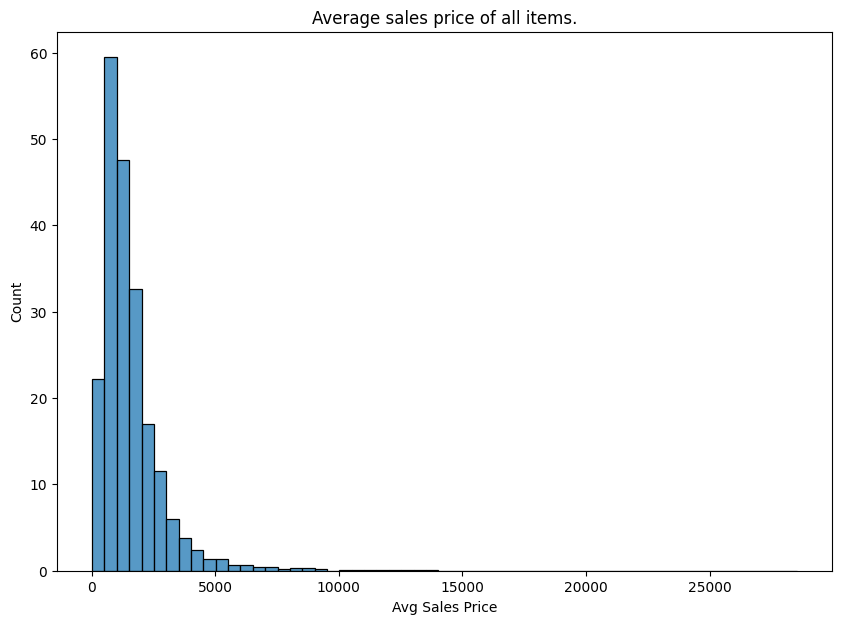

In [25]:
fig = plt.figure(figsize = (10,7))
ax = sns.histplot(data = df_item_feature,
                  x = 'scaled_avg_sale_price',                 
                  bins = 210,
                  stat = 'frequency',
                  binwidth = 500,
                  #binrange = (0,10000)
                  )

ax.set_title("Average sales price of all items.")
ax.set_xlabel("Avg Sales Price")
ax.set_ylabel("Count")
#ax.set_xlim(0,180)
plt.show()

### **Question:** Which price range has the max sales? ###

price_range_0_500             2534671
price_range_501_1000          7755246
price_range_1001_1500         6520379
price_range_1501_2000         4964891
price_range_2001_4000         4789911
price_range_more_then_4000     596220
dtype: int64

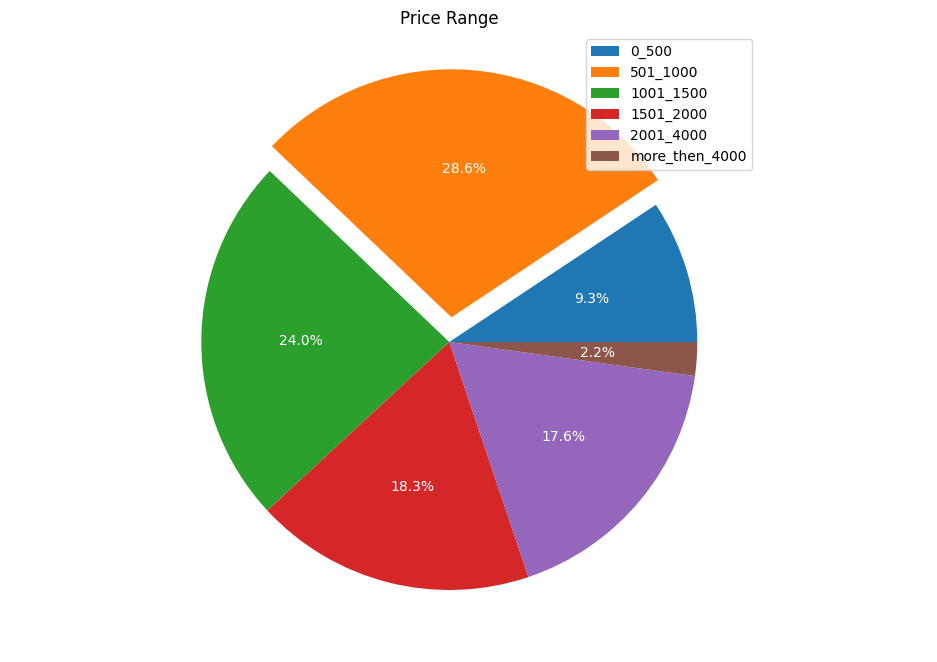

In [29]:
#Count number of tran belong to each of these ranges
dfprice_ranges = train_tran[['price_range_0_500', 'price_range_501_1000',
                             'price_range_1001_1500', 'price_range_1501_2000',
                             'price_range_2001_4000', 'price_range_more_then_4000']].sum()
#dfprice_ranges #type(dfprice_ranges): pandas.core.series.Series


#Plot to visualiser the which price range has max sale
#Dynamic explode the element in pie https://stackoverflow.com/questions/61165611/matplotlib-explode-largest-array-value
explode = np.zeros(len(dfprice_ranges))
explode[dfprice_ranges.argmax()] = 0.1 #.value_count

display(dfprice_ranges)
print("="*100)

fig_WS = plt.figure( figsize = (8,10))

ax = plt.pie(dfprice_ranges, 
        labels = list(dfprice_ranges.index), 
        autopct='%1.1f%%', 
        explode = explode,  
        textprops={'color':"w"}
       )
plt.legend(['0_500','501_1000',
            '1001_1500','1501_2000',
            '2001_4000','more_then_4000'], 
           loc = "upper right")
plt.title("Price Range")
plt.show()

**Observartion**: Max sales we see are in price range between 500 to 1000.

### **Question**: What price point user purchase? ###
#### 1. Over all
#### 2. Last 8 week


In [8]:
#Overall purchase

pvt_overall_purchase_price = pd.pivot_table(data = train_tran, 
                                            index = ['customer_id'], 
                                            columns = ['price_range_0_500','price_range_501_1000',
                                                       'price_range_1001_1500','price_range_1501_2000',
                                                       'price_range_2001_4000','price_range_more_then_4000'], 
                                            values = 'article_id',
                                            aggfunc = 'count',
                                            fill_value = 0,
                                            margins = True, margins_name = 'Total',
                                            #sort = True #Sort is an expensive operation
                                            )

pvt_overall_purchase_price.drop(index = ['Total'], inplace = True) #Drop row with index 'Total'
pvt_overall_purchase_price = pvt_overall_purchase_price.reset_index(level = 0)

#Rename column name instead on 0,1, ... to proper name
pvt_overall_purchase_price.columns = ['customer_id',
                                      'total_item_purchase_price_more_then_4000', 
                                      'total_item_purchase_price_2001_4000', 
                                      'total_item_purchase_price_1501_2000',
                                      'total_item_purchase_price_1001_1500',
                                      'total_item_purchase_price_501_1000',
                                      'total_item_purchase_price_0_500', 
                                      'Total']
pvt_overall_purchase_price.set_index(['customer_id'], inplace = True)

#User latent feature to generate w.r.t price they purchase are calculated in 
print('*'*50 + ' Customer purchase for price range' + '*'*50)
display(pvt_overall_purchase_price.head())
print('\n')

************************************************** Customer purchase for price range**************************************************


,total_item_purchase_price_more_then_4000,total_item_purchase_price_2001_4000,total_item_purchase_price_1501_2000,total_item_purchase_price_1001_1500,total_item_purchase_price_501_1000,total_item_purchase_price_0_500,Total
customer_id,,,,,,,
-9223352921020755230,1,1,5,1,2,0,10
-9223343869995384291,3,38,37,27,25,4,134
-9223321797620987725,0,0,0,0,1,1,2
-9223319430705797669,0,0,0,2,6,0,8
-9223303410580442681,3,2,0,0,1,0,6


In [38]:
#Average purchase price of item in  overall.

df_avg_user_purchase = train_tran.groupby('customer_id').agg(scaled_avg_sale_price = ('scale_price', 'mean'), 
                                                             scaled_median_sale_price = ('scale_price', 'median'), 
                                                             avg_sale_price = ('price', 'mean'),
                                                             median_sale_price = ('price', 'median'),
                                                             sales_cnt = ('t_dat', 'count')
                                                             ).reset_index()

df_avg_user_purchase.head()

,customer_id,scaled_avg_sale_price,scaled_median_sale_price,avg_sale_price,median_sale_price,sales_cnt
0,-9223352921020755230,2013.900000,1873.0,0.036407,0.033875,10
1,-9223343869995384291,1799.895522,1773.5,0.032532,0.032074,134
2,-9223321797620987725,515.000000,515.0,0.009308,0.009308,2
3,-9223319430705797669,821.875000,843.0,0.014854,0.015236,8
4,-9223303410580442681,3514.000000,3748.5,0.063538,0.067749,6


In [11]:
#Last 8 week
last_tran_date_record = train_tran.t_dat.max() 
last_8week_tran = train_tran[train_tran.t_dat >= (last_tran_date_record - timedelta(weeks = 8))]

pvt_last8week_purchase_price = pd.pivot_table(data = last_8week_tran, 
                                              index = ['customer_id'], 
                                              columns = ['price_range_0_500','price_range_501_1000',
                                                         'price_range_1001_1500','price_range_1501_2000',
                                                         'price_range_2001_4000','price_range_more_then_4000'], 
                                              values = 'article_id',
                                              aggfunc = 'count',
                                              fill_value = 0,
                                              margins = True, margins_name = 'Total',
                                              #sort = True #Sort is an expensive operation
                                              )

pvt_last8week_purchase_price.drop(index = ['Total'], inplace = True) #Drop row with index 'Total'
pvt_last8week_purchase_price = pvt_last8week_purchase_price.reset_index(level = 0)

#Rename column name instead on 0,1, ... to proper name
pvt_last8week_purchase_price.columns = ['customer_id',
                                        'total_item_purchase_price_last_8week_more_then_4000', 
                                        'total_item_purchase_price_last_8week_2001_4000', 
                                        'total_item_purchase_price_last_8week_1501_2000',
                                        'total_item_purchase_price_last_8week_1001_1500',
                                        'total_item_purchase_price_last_8week_501_1000',
                                        'total_item_purchase_price_last_8week_0_500', 
                                        'Total']
#pvt_output.index.names = ['']
pvt_last8week_purchase_price.set_index(['customer_id'], inplace = True)


#What % of user purchase overall belong to price range
for col in pvt_last8week_purchase_price.columns:
    if col != 'Total':        
        new_col_name = col[len('total_item_purchase_price_'):] +"_pct_ctb" #"pct" stands for percentage(pct) of the total transaction contribution(ctb) is with in the price range
        pvt_last8week_purchase_price[new_col_name] = round(pvt_last8week_purchase_price[col]/pvt_last8week_purchase_price['Total'],2) 

pvt_last8week_purchase_price.drop(columns = ['Total'], axis = 1, inplace = True)
pvt_last8week_purchase_price.fillna(value = 0, inplace = True)
#pvt_output

#User latent feature to generate w.r.t price they purchase are calculated in 
print('\n')
print('*'*50 + ' Customer purchase for price range in last 8 week' + '*'*50)
display(pvt_last8week_purchase_price.head())



************************************************** Customer purchase for price range in last 8 week**************************************************


,total_item_purchase_price_last_8week_more_then_4000,total_item_purchase_price_last_8week_2001_4000,total_item_purchase_price_last_8week_1501_2000,total_item_purchase_price_last_8week_1001_1500,total_item_purchase_price_last_8week_501_1000,total_item_purchase_price_last_8week_0_500,last_8week_more_then_4000_pct_ctb,last_8week_2001_4000_pct_ctb,last_8week_1501_2000_pct_ctb,last_8week_1001_1500_pct_ctb,last_8week_501_1000_pct_ctb,last_8week_0_500_pct_ctb
customer_id,,,,,,,,,,,,
-9223352921020755230,0,0,0,0,2,0,0.0,0.00,0.00,0.00,1.00,0.0
-9223343869995384291,1,4,0,3,2,0,0.1,0.40,0.00,0.30,0.20,0.0
-9223290575350349271,0,0,1,1,4,0,0.0,0.00,0.17,0.17,0.67,0.0
-9223279922255655589,0,1,0,4,3,0,0.0,0.12,0.00,0.50,0.38,0.0
-9223251502792607675,0,0,1,1,2,0,0.0,0.00,0.25,0.25,0.50,0.0


In [40]:
#Average purchase price of item in last 8 week.
df_avg_user_purchase_8Week = last_8week_tran.groupby('customer_id').agg(scaled_avg_sale_price = ('scale_price', 'mean'), 
                                                                        scaled_median_sale_price = ('scale_price', 'median'),
                                                                        avg_sale_price = ('price', 'mean'),
                                                                        median_sale_price = ('price', 'median'),
                                                                        sales_cnt = ('t_dat', 'count')
                                                                        ).reset_index()

df_avg_user_purchase_8Week.head()

,customer_id,scaled_avg_sale_price,scaled_median_sale_price,avg_sale_price,median_sale_price,sales_cnt
0,-9223352921020755230,796.00,796.0,0.014389,0.014389,2
1,-9223343869995384291,2054.20,1873.5,0.037140,0.033875,10
2,-9223290575350349271,1171.00,937.0,0.021179,0.016937,6
3,-9223279922255655589,1452.25,1264.5,0.026260,0.022858,8
4,-9223251502792607675,1241.00,1171.0,0.022446,0.021179,4


***Note***: *Why not conside the percentage of over all item purchase for a given price range?*
*Because we just want to understand, which price range does user purchase item till date and give more importance to what is the price they have purchase in last 6 weeks*

#### Save the train transaction file with scaled  and split price feature ####

In [16]:
train_tran.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'online_sale',
       'single_tran_by_user', 'scale_price', 'price_range_0_500',
       'price_range_501_1000', 'price_range_1001_1500',
       'price_range_1501_2000', 'price_range_2001_4000',
       'price_range_more_then_4000'],
      dtype='object')

In [17]:
#Drop the columns that are not required
train_tran.drop(['single_tran_by_user'], axis = 1, inplace = True)

In [18]:
train_tran.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'online_sale',
       'scale_price', 'price_range_0_500', 'price_range_501_1000',
       'price_range_1001_1500', 'price_range_1501_2000',
       'price_range_2001_4000', 'price_range_more_then_4000'],
      dtype='object')

### **Question**: What average order value of user per transaction ? ###

In [6]:
df_avg_purchase_price_per_transaction = train_tran.groupby(['customer_id','t_dat']).agg(avg_price_per_order = ('price', 'mean'),
                                                                                        scaled_avg_price_per_order = ('scale_price' , 'mean')
                                                                                        ).reset_index()

### **Question:** Is there any preference of color in last 6 week? ###

In [ ]:
last_tran_date_record = train_tran.t_dat.max() 
last_8week_tran = train_tran[train_tran.t_dat >= (last_tran_date_record - timedelta(weeks = 8))]

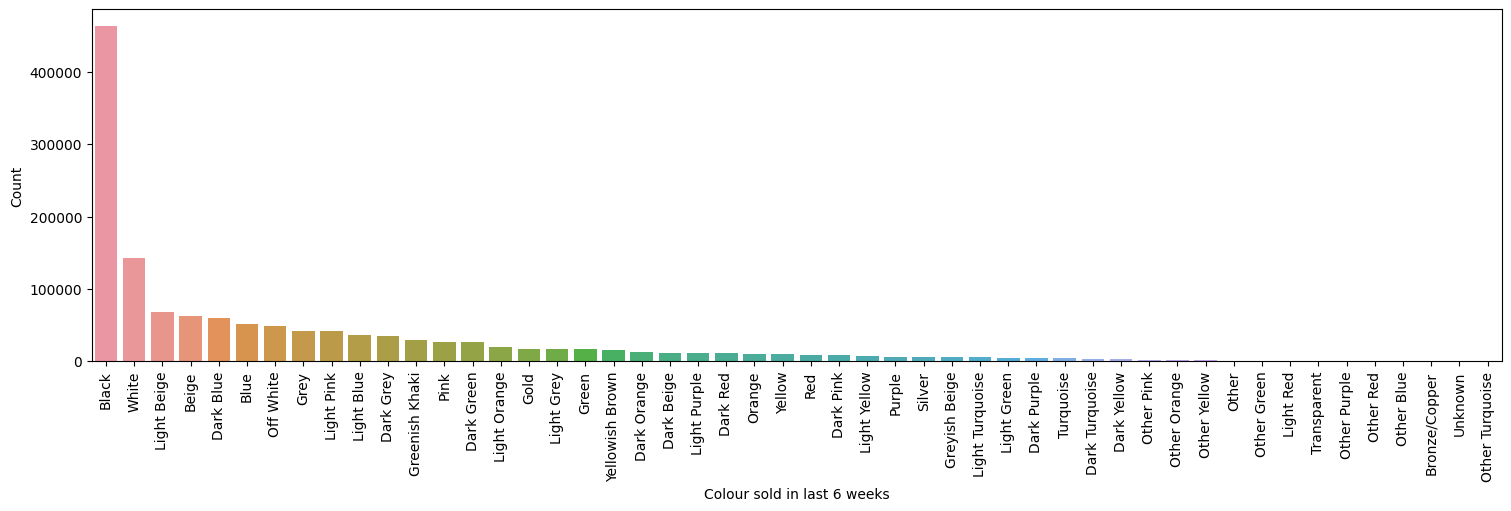

In [ ]:
fig_WS = plt.figure(num = 1, 
                    figsize = (15,5), 
                    dpi = 100, 
                    clear = True,
                    constrained_layout =  True
                    )

ax = sns.countplot(data = last_8week_tran, 
                   x = 'colour_group_name',
                   order = last_6week_tran['colour_group_name'].value_counts().index
                   )

ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation = 90                   
                   )

ax.set_xlabel("Colour sold in last 8 weeks")
ax.set_ylabel("Count")

plt.show()
fig_WS.clf()

**Observartion:** Black color items are sold the higest. 

**We have garment where color type in "Unknown" lets look at the item to better understand this color label**

In [ ]:
hlpimage.show_item_img(last_8week_tran[last_8week_tran.colour_group_name == 'Unknown'].article_id)

**Observation:** Item with color as "Unknown" looks like black color. But not sure.

In [ ]:
pd.pivot_table(data = last_8week_tran, 
              index = ['customer_id'], 
              columns = ['colour_group_name'], 
              values = 'article_id',
              aggfunc = 'count',
              fill_value = 0             
              )

colour_group_name,Beige,Black,Blue,Bronze/Copper,Dark Beige,Dark Blue,Dark Green,Dark Grey,Dark Orange,Dark Pink,...,Pink,Purple,Red,Silver,Transparent,Turquoise,Unknown,White,Yellow,Yellowish Brown
customer_id,,,,,,,,,,,,,,,,,,,,,
-9223352921020755230,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-9223343869995384291,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
-9223290575350349271,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-9223279922255655589,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-9223251502792607675,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9222733909628763172,0,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9222940818992675193,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9223099843213569889,0,4,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


***Note:** Color represenation will be sparce matrix as seen above. so we can not use it since this will increase the size of the feature*

### Question: What average age group of customer do those item are purchase? ### 

In [4]:
max_t_date = train_tran.t_dat.max()
min_t_date = train_tran.t_dat.min()

print(f'Transaction records from: {min_t_date} to {max_t_date}')

Transaction records from: 2018-09-20 00:00:00 to 2020-09-22 00:00:00


In [5]:

train_tran = train_tran.merge(customer[['customer_id','age']], on = 'customer_id', how = 'left')

del customer
gc.collect()

0

In [6]:
train_tran.head()

,t_dat,customer_id,article_id,price,online_sale,scale_price,price_range_0_500,price_range_501_1000,price_range_1001_1500,price_range_1501_2000,price_range_2001_4000,price_range_more_then_4000,age
0,2018-09-20,-6846340800584936,541518023,0.030487,True,1686,0,0,0,1,0,0,24
1,2018-09-20,-8334631767138808638,505221004,0.015236,True,843,0,1,0,0,0,0,32
2,2018-09-20,-8334631767138808638,685687003,0.016937,True,937,0,1,0,0,0,0,32
3,2018-09-20,-8334631767138808638,685687004,0.016937,True,937,0,1,0,0,0,0,32
4,2018-09-20,-8334631767138808638,685687001,0.016937,True,937,0,1,0,0,0,0,32


In [13]:
avg_age_group_item_seller = (train_tran.groupby('article_id').agg(avg_age_grp_item_seller = ('age', 'mean'),
                                                                   median_age_grp_item_seller = ('age','median')
                                                                ).reset_index())

avg_age_group_item_seller.head()

,article_id,avg_age_grp_item_seller,median_age_grp_item_seller
0,108775015,34.352915,30.0
1,108775044,35.733827,31.0
2,108775051,34.625000,31.0
3,110065001,37.972370,36.0
4,110065002,38.735230,39.0


### Lets merge catagorical feature of items which will provide item feature vector/ embeding that describe the item ##

We are going to create a new column as:
product_desc = product_type_name + product_group_name + index_group_name + index_name + department_name

In [15]:
#train_tran = pd.read_pickle(consts.TRANSACTION_DATA_SCALED_PRICE_SPLIT_PRICE_BY_RANGE, compression = 'gzip')
display(train_tran.head())
train_tran.columns

,t_dat,customer_id,article_id,price,online_sale,scale_price,price_range_0_500,price_range_501_1000,price_range_1001_1500,price_range_1501_2000,price_range_2001_4000,price_range_more_then_4000,age
0,2018-09-20,-6846340800584936,541518023,0.030487,True,1686,0,0,0,1,0,0,24
1,2018-09-20,-8334631767138808638,505221004,0.015236,True,843,0,1,0,0,0,0,32
2,2018-09-20,-8334631767138808638,685687003,0.016937,True,937,0,1,0,0,0,0,32
3,2018-09-20,-8334631767138808638,685687004,0.016937,True,937,0,1,0,0,0,0,32
4,2018-09-20,-8334631767138808638,685687001,0.016937,True,937,0,1,0,0,0,0,32


Index(['t_dat', 'customer_id', 'article_id', 'price', 'online_sale',
       'scale_price', 'price_range_0_500', 'price_range_501_1000',
       'price_range_1001_1500', 'price_range_1501_2000',
       'price_range_2001_4000', 'price_range_more_then_4000', 'age'],
      dtype='object')

In [ ]:
"""
items_feature = train_tran[['article_id', 'product_code', 
                            #'scale_price', #We shall use the range feature
                            'price_range_0_500', 'price_range_501_1000',
                            'price_range_1001_1500', 'price_range_1501_2000',
                            'price_range_2001_4000', 'price_range_more_then_4000',            
                            'new_product_type_name',  'colour_group_name', 
                            'clean_department_name', 'clean_index_name',  'clean_index_group_name', 
                            'clean_product_group_name']].drop_duplicates(keep = 'first')

#'product_type_name' Forgot instead used 'new_product_type_name'. Try if model fail to perform we can use 'product_type_name' and 'new_product_type_name' together then

"""

In [18]:
#Merge to create new column  garment_group_name =  index_group_name + index_name + department_name
import re

garment_group_name = []
for (index_name, index_grp, department_name) in zip(df_article['clean_index_name'], df_article['clean_index_group_name'], df_article['clean_department_name']):

    #Add index_grp
    merge_str = index_grp

    #Merge index_name
    pattern = index_name.split(' ')
    for str in pattern:
        if re.search(str, merge_str) == None:
            merge_str += " "+ str

    #Merge department_name
    pattern = department_name.split(' ')
    for str in pattern:
        if re.search(str, merge_str) == None:
            merge_str += " "+ str

    garment_group_name.append(merge_str)

items_feature = pd.DataFrame()
items_feature['article_id'] = df_article['article_id']
items_feature['garment_group_name'] = garment_group_name
items_feature['product_group_name'] = df_article['clean_product_group_name']
items_feature['product_type_name'] = df_article['new_product_type_name']

"""
items_feature.rename(columns = {'clean_product_group_name': 'product_group_name',
                                'new_product_type_name': 'product_type_name'
                     },
                     #axis = 1, #No need to mention axis if we specify "columns = " parmater explictly
                     inplace = True)   
"""                  
items_feature['product_desc'] = items_feature['product_type_name'] + " " + items_feature['product_group_name'] + " " + items_feature['garment_group_name']

"""
items_feature = items_feature[['article_id', 'product_code', 'product_desc','colour_group_name',
                                'price_range_0_500' , 'price_range_501_1000',	
                                'price_range_1001_1500', 'price_range_1501_2000', 
                                'price_range_2001_4000', 'price_range_more_then_4000']]
"""

print(f'Shape: {items_feature.shape}')
display(items_feature.head())

Shape: (104655, 5)


,article_id,garment_group_name,product_group_name,product_type_name,product_desc
0,108775015,Ladieswear Jersey,Garment Upper body,Vest top,Vest top Garment Upper body Ladieswear Jersey
1,108775044,Ladieswear Jersey,Garment Upper body,Vest top,Vest top Garment Upper body Ladieswear Jersey
2,108775051,Ladieswear Jersey,Garment Upper body,Vest top,Vest top Garment Upper body Ladieswear Jersey
3,110065001,Ladieswear Lingerie Clean,Underwear,Bra,Bra Underwear Ladieswear Lingerie Clean
4,110065002,Ladieswear Lingerie Clean,Underwear,Bra,Bra Underwear Ladieswear Lingerie Clean


### Convert Color feature to RGB ###

***Note:*** *If we are planing to use webcolor then we need to install for new enviornment*

         !pip install webcolors 

In [20]:
df_article.colour_group_name.unique()

array(['Black', 'White', 'Off White', 'Light Beige', 'Beige', 'Grey',
       'Light Blue', 'Light Grey', 'Dark Blue', 'Dark Grey', 'Pink',
       'Dark Red', 'Greyish Beige', 'Light Orange', 'Silver', 'Gold',
       'Light Pink', 'Dark Pink', 'Yellowish Brown', 'Blue',
       'Light Turquoise', 'Yellow', 'Greenish Khaki', 'Dark Yellow',
       'Other Pink', 'Dark Purple', 'Red', 'Transparent', 'Dark Green',
       'Other Red', 'Turquoise', 'Dark Orange', 'Other', 'Orange',
       'Dark Beige', 'Other Yellow', 'Light Green', 'Other Orange',
       'Purple', 'Light Red', 'Light Yellow', 'Green', 'Light Purple',
       'Dark Turquoise', 'Other Purple', 'Bronze/Copper',
       'Other Turquoise', 'Other Green', 'Other Blue', 'Unknown'],
      dtype=object)

In [24]:
df_article = df_article[['article_id','colour_group_name','perceived_colour_value_name','perceived_colour_master_name']]

In [ ]:
import webcolors
webcolors.name_to_rgb('darkbeige', spec = 'css3')#'html4' css3

ValueError: 'darkbeige' is not defined as a named color in css3

In [ ]:
webcolors.name_to_rgb('Orange', spec = 'css3')

IntegerRGB(red=255, green=165, blue=0)

In [ ]:
#https://matplotlib.org/stable/gallery/color/named_colors.html
#https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.to_rgb.html
from matplotlib.colors import to_rgb

to_rgb('Orange')

(1.0, 0.6470588235294118, 0.0)

In [ ]:
to_rgb('darkbeige')

ValueError: Invalid RGBA argument: 'darkbeige'

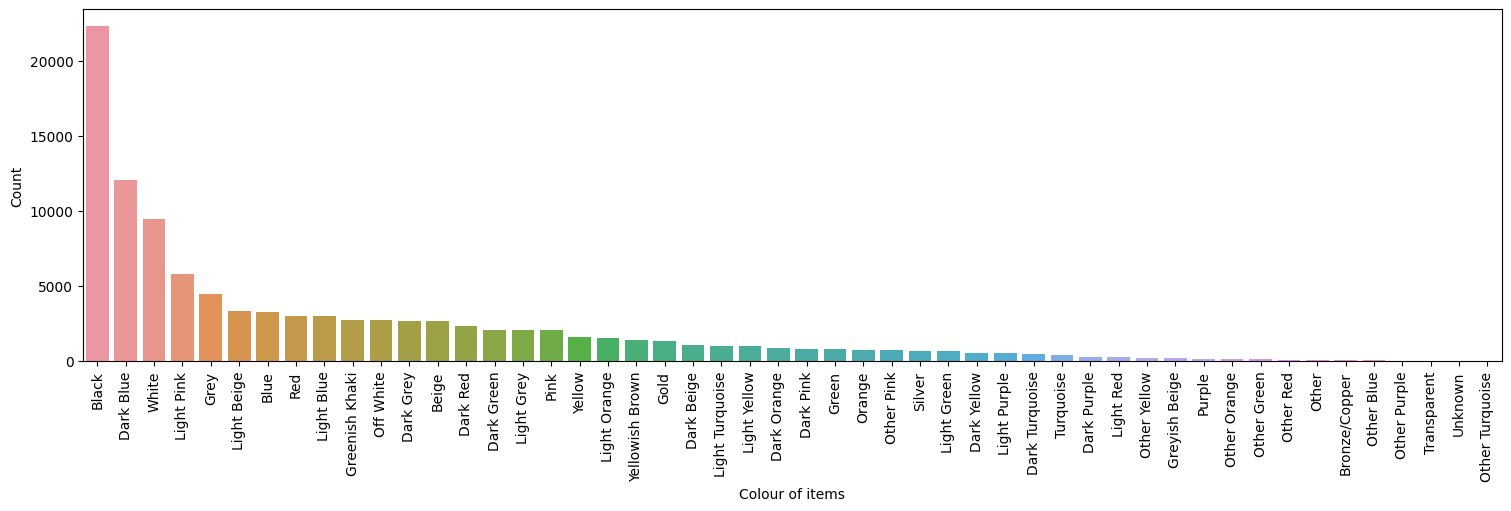

In [21]:
#Which color items are mostly there in the item cataglog

fig_WS = plt.figure(num = 1, 
                    figsize = (15,5), 
                    dpi = 100, 
                    clear = True,
                    constrained_layout =  True
                    )

ax = sns.countplot(data = df_article, 
                   x = 'colour_group_name',
                   order = df_article['colour_group_name'].value_counts().index
                   )

ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation = 90                   
                   )

ax.set_xlabel("Colour of items")
ax.set_ylabel("Count")

plt.show()
fig_WS.clf()

In [25]:
df_article[df_article.colour_group_name == 'Dark Beige'].head()

,article_id,colour_group_name,perceived_colour_value_name,perceived_colour_master_name
274,212766042,Dark Beige,Medium Dusty,Mole
325,219075028,Dark Beige,Dark,Beige
432,241412043,Dark Beige,Dark,Beige
460,244267027,Dark Beige,Medium Dusty,Brown
915,301687016,Dark Beige,Dark,Beige


In [26]:
df_article[df_article.colour_group_name ==  'Transparent'].head()

,article_id,colour_group_name,perceived_colour_value_name,perceived_colour_master_name
139,186262013,Transparent,Light,White
1101,318035003,Transparent,Light,White
1106,318035022,Transparent,Light,White
1108,318035025,Transparent,Light,White
1538,356438015,Transparent,Light,White


**Observartion:**
* Cleaning is required as certain color name has "Other" word in them. Also we should remove special char.
* Most of the color name are not available  in css3 or html4 in both matplotlib and webcolors.
* Most of the item in the catalogue are of black color. Also items that are sold top are of black color. So for item color that are not defined under *css3* we could replace that with **Black** color.
* In some case "perceived_colour_master_name" feature provide master color of the "colour_group_name" which are available in css3 list

So we shall use first try to convert the name of the color in "*colour_group_name*", if the fail will use "*perceived_colour_master_name*" and even if that fail we shall label that items color as **Black**

In [28]:
import re
import webcolors

def clean_color(color_name):
    
    #Remove any special char
    pat = r'[^a-zA-Z]'
    color_name = re.sub(pat, ' ', color_name)

    #Remove extra space
    color_name = ' '.join(color_name.split())

    #Remove "Other"
    color_name = color_name.replace("Other", "")

    #Convert to lower
    color_name = color_name.lower()

    #Remove blank space
    color_name = color_name.replace(" ","")
    
    return color_name

#Code to try clean_color method
#color_name = "Light Grey"
#clean_color_name = clean_color(color_name)

#https://webcolors.readthedocs.io/en/1.12/contents.html#spec-constants 
# name_to_rgb: Convert name to RGB, We need to normalize the value since they will be value from 0-255  
# name_to_rgb_percent: Convert name to RGB in percenatage. Tried using it but return value was string in form of '100%' addition  format was require to remove '%'
def get_color_name(color_name, master_color_name):
    
    closest_color_rgb = actual_color_rgb = None
     
    try:        
        closest_color_rgb = actual_color_rgb = webcolors.name_to_rgb(clean_color(color_name))   
    except ValueError:
        actual_color_rgb = None
        
        try:            
            closest_color_rgb = webcolors.name_to_rgb(clean_color(master_color_name))            
        except ValueError:          
            #Based on the article master database we see that most of the item they have are in black color. Also number of sales we see is are in black color  
            closest_color_rgb = webcolors.name_to_rgb('black') 
    
    if actual_color_rgb == None:
        return closest_color_rgb
    
    return actual_color_rgb

def transform_rgb(color_name, master_color_name):

    rgb = get_color_name(color_name, master_color_name)
    #Divide it by 255 to normalize the 
    return rgb.red/255, rgb.green/255 , rgb.blue/255

In [29]:
data = df_article.apply(lambda row: transform_rgb(row.colour_group_name, row.perceived_colour_master_name), axis = 1)
df_rgb = pd.DataFrame(list(data), columns = ['Red', 'Green', 'Blue'])
df_article['Red'] = df_rgb.Red
df_article['Green'] = df_rgb.Green
df_article['Blue'] = df_rgb.Blue
df_article.head()

,article_id,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,Red,Green,Blue
0,108775015,Black,Dark,Black,0.0,0.0,0.0
1,108775044,White,Light,White,1.0,1.0,1.0
2,108775051,Off White,Dusty Light,White,1.0,1.0,1.0
3,110065001,Black,Dark,Black,0.0,0.0,0.0
4,110065002,White,Light,White,1.0,1.0,1.0


In [31]:
del [df_article]
gc.collect()

3045

**Observartion:** 
* There are set of user that are there in the validation and test data that are not in the train dataset. Need is to removes those users that are not train dataset as this will not help with the model accuracy.


### Feature Enginering to split transaction date ###

In [4]:
#https://docs.python.org/3/library/datetime.html#datetime.date.weekday

def week_number_of_month(date_value):
     return (date_value.isocalendar()[1] - date_value.replace(day=1).isocalendar()[1] + 1)  

train_tran['year'] = train_tran.t_dat.dt.year
train_tran['month'] = train_tran.t_dat.dt.month
train_tran['week_of_month']  = train_tran.t_dat.apply(week_number_of_month)